In [1]:
%tensorflow_version 2.x
import tensorflow as tf
from tensorflow import keras
from tqdm.autonotebook import tqdm
import numpy as np
from tensorflow.keras.layers import *
import matplotlib.pyplot as plt

TensorFlow 2.x selected.


/usr/local/lib/python3.6/dist-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [0]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
x_train = np.float32((x_train / 255)*2 - 1).reshape(-1,28,28,1)
x_test = np.float32((x_test / 255)*2 - 1).reshape(-1,28,28,1)
y_train = np.float32(keras.utils.to_categorical(y_train))
y_test = np.float32(keras.utils.to_categorical(y_test))

In [0]:
def plot():
    eye = np.float32(np.eye(10))
    im = Gen([tf.random.normal((10,)+noise_shape),eye])
    d = Disc([im,eye]).numpy()
    im = im.numpy().reshape(-1,28,28)
    
    plt.figure(figsize = (18/12*10,18/12*(1.1)))
    for i in range(10):
        plt.subplot(1,10,i+1)
        plt.title(d[i])
        plt.imshow(im[i],cmap = 'Greys')
    plt.show()

In [0]:
dropout = 0.5
leak = 0.3

Gen_Noise_Input = Input(shape = (100,))
Gen_Label_Input = Input(shape = (10,))

x_noise = Dense(7*7*256, input_shape = (100,),use_bias = False)(Gen_Noise_Input)
x_noise = BatchNormalization()(x_noise)
x_noise = LeakyReLU(leak)(x_noise)
x_noise = Reshape((7,7,256))(x_noise)

x_label = Dense(7*7*10, input_shape = (10,), use_bias = False)(Gen_Label_Input)
x_label = BatchNormalization()(x_label)
x_label = LeakyReLU(leak)(x_label)
x_label = Reshape((7,7,10))(x_label)

x = Concatenate(axis = 3)([x_noise, x_label])

Gen_Network = keras.Sequential([
    Conv2D(128, 5, padding = 'same', use_bias = False, input_shape = (7,7,266)),
    BatchNormalization(),
    LeakyReLU(leak),
    
    UpSampling2D(),
    Conv2D(64,5,padding = 'same', use_bias = False),
    
    BatchNormalization(),
    LeakyReLU(leak),
    
    UpSampling2D(),
    Conv2D(1,5,padding = 'same', use_bias = False, activation = 'tanh'),  
])

Gen = keras.Model(inputs = [Gen_Noise_Input, Gen_Label_Input], outputs = Gen_Network(x))

Disc_Image_Input = Input(shape = (28,28,1))
Disc_Label_Input = Input(shape = (10,))

x_label = Dense(28*28*10, input_shape = (10,), use_bias = False)(Disc_Label_Input)
x_label = BatchNormalization()(x_label)
x_label = LeakyReLU(leak)(x_label)
x_label = Reshape((28,28,10))(x_label)

x = Concatenate(axis = 3)([Disc_Image_Input, x_label])

Disc_Network = keras.Sequential([
    Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=(28, 28, 11)),
    BatchNormalization(),
    LeakyReLU(),
    
    Conv2D(128, (5, 5), strides=(2, 2), padding='same'),
    BatchNormalization(),
    LeakyReLU(),
    
    Conv2D(256, (5, 5), strides=(2, 2), padding='same'),
    BatchNormalization(),
    LeakyReLU(),
    
    Flatten(),
    Dense(1, activation = 'sigmoid'),
])

Disc = keras.Model(inputs = [Disc_Image_Input, Disc_Label_Input], outputs = Disc_Network(x))

In [0]:
Gen_Op = keras.optimizers.Adam(1e-4)
Disc_Op = keras.optimizers.Adam(1e-4)

In [0]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=False)

/usr/local/lib/python3.6/dist-packages/matplotlib/text.py:1150: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


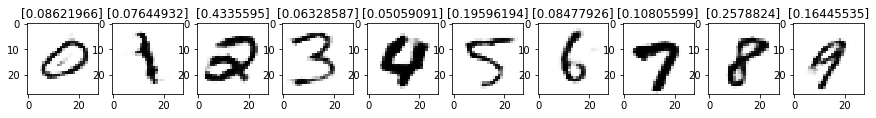

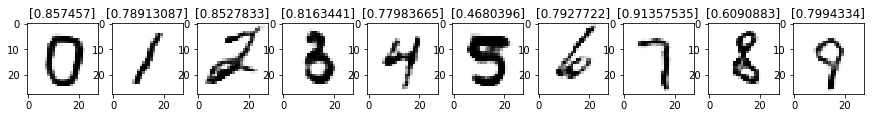

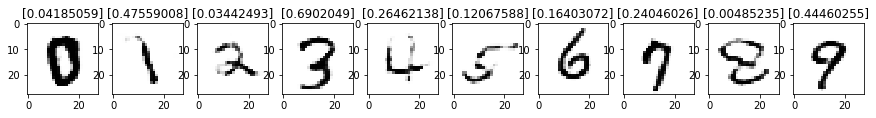

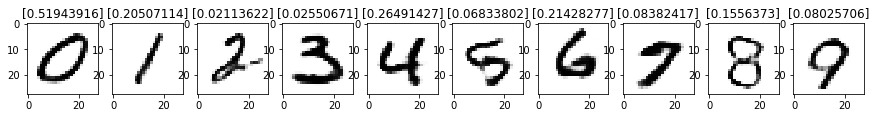

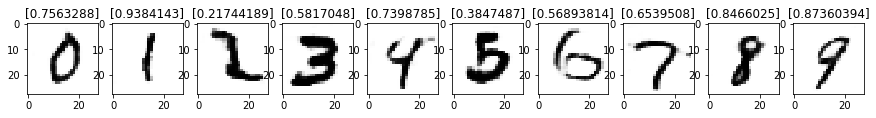

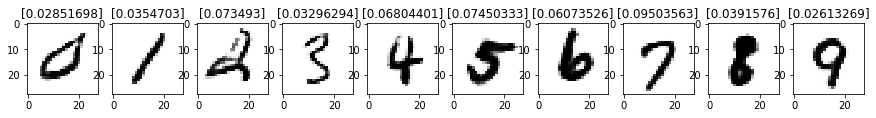

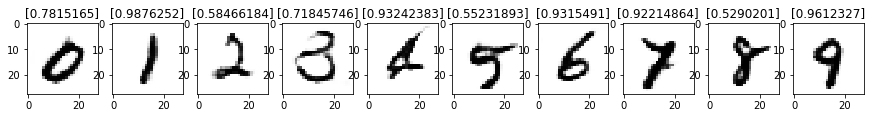

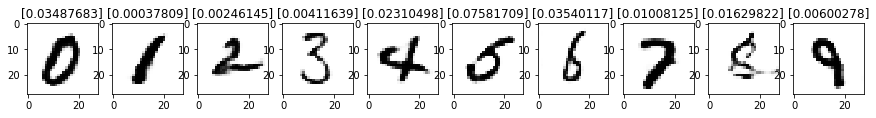

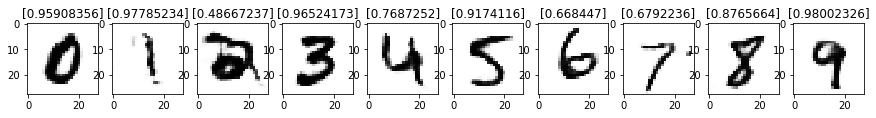

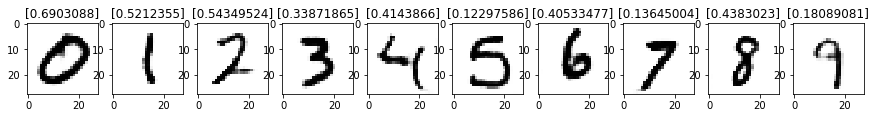

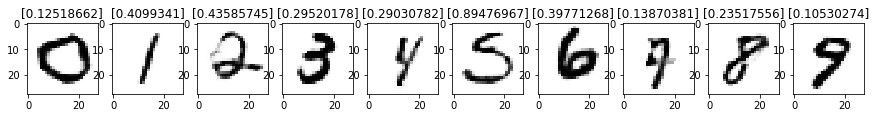

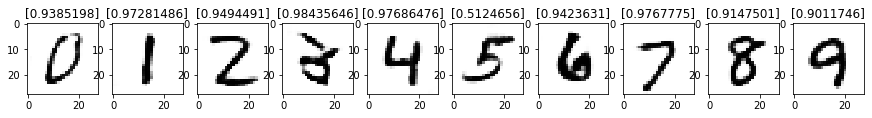

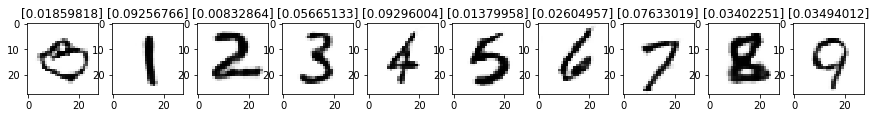

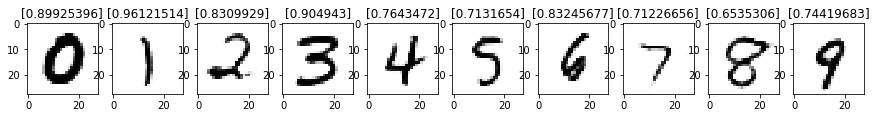

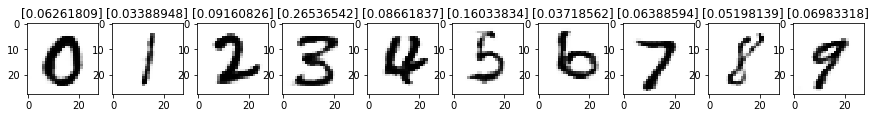

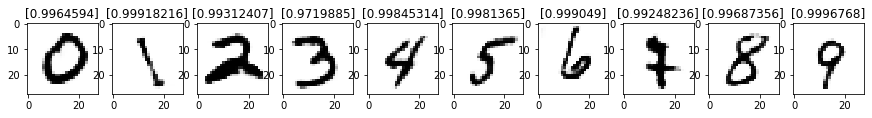

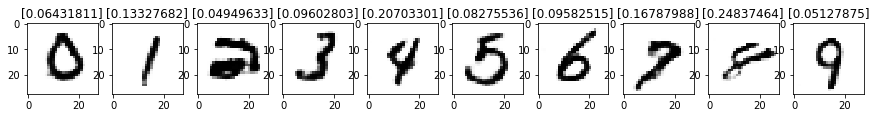

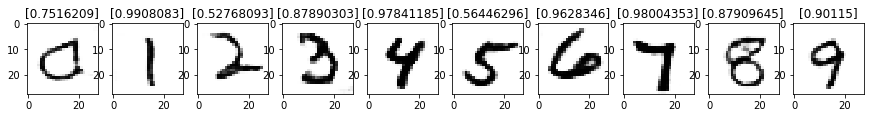

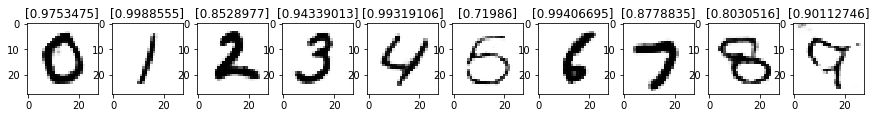

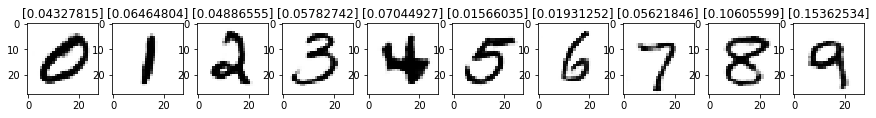

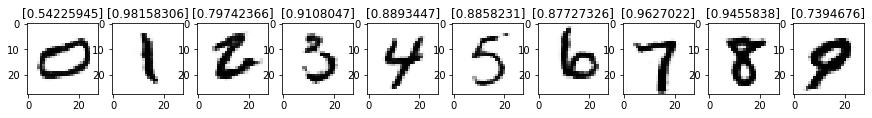

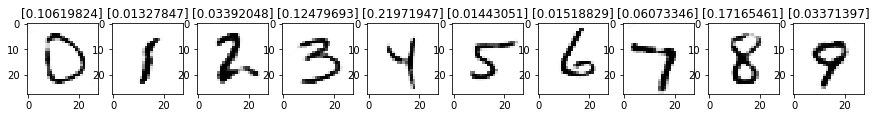

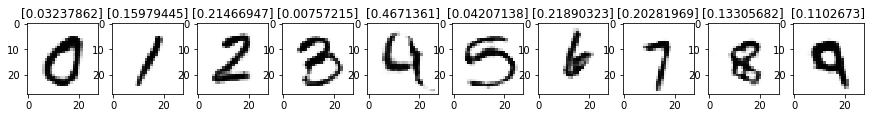

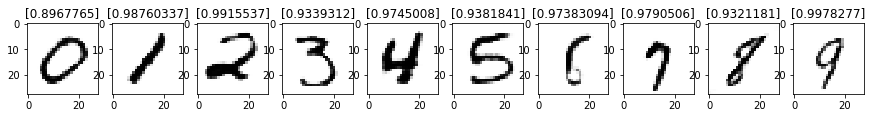

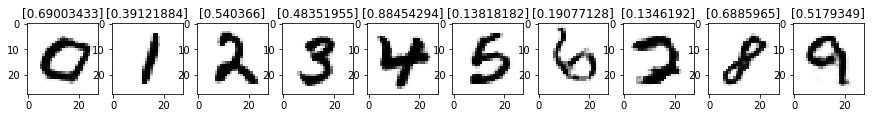

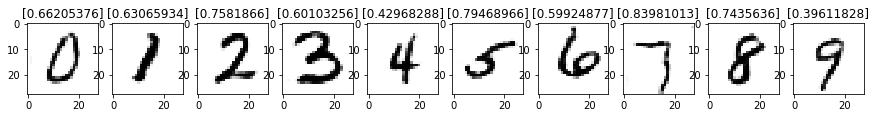

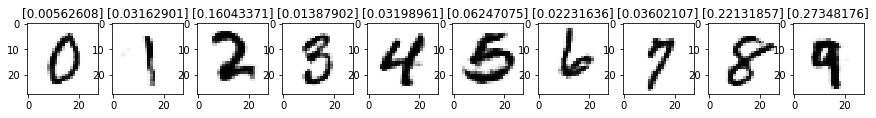

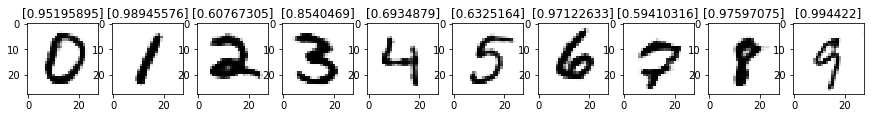

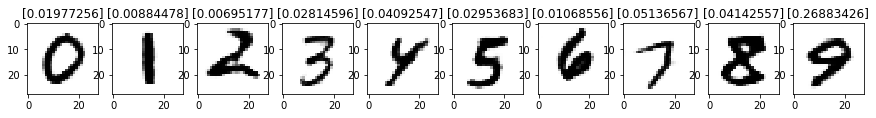

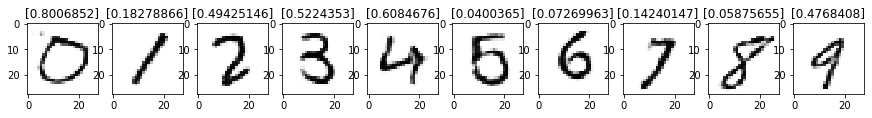

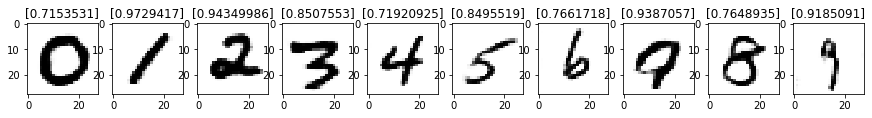

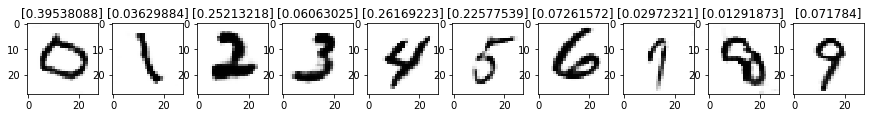

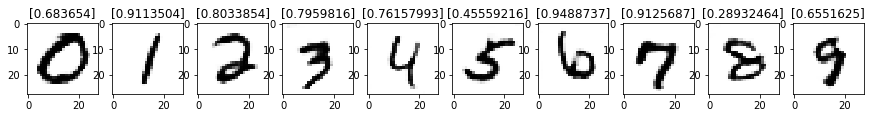

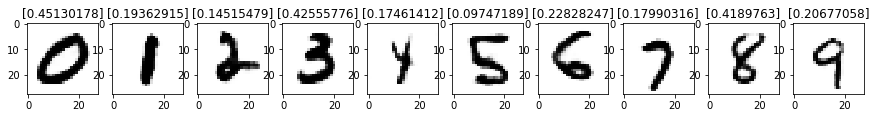

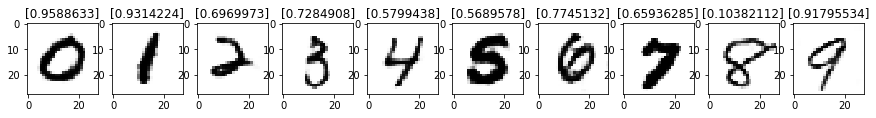

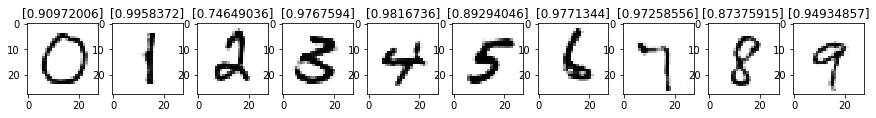

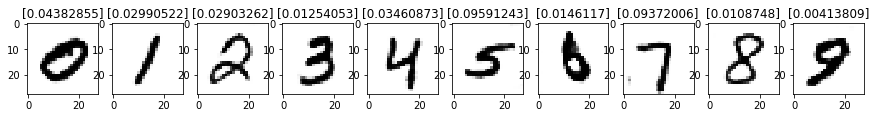

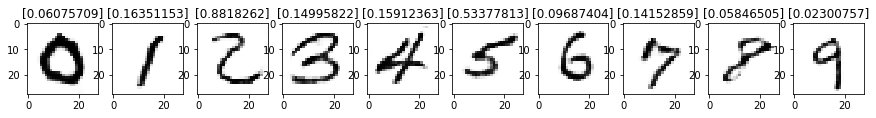

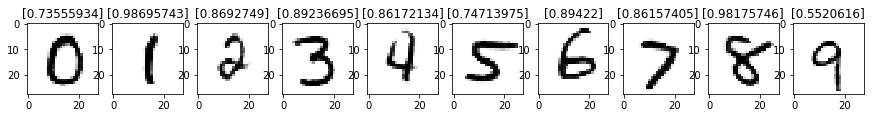

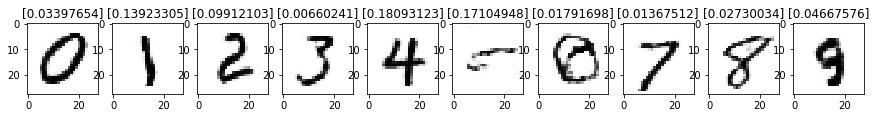

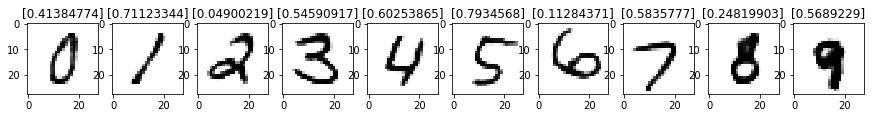

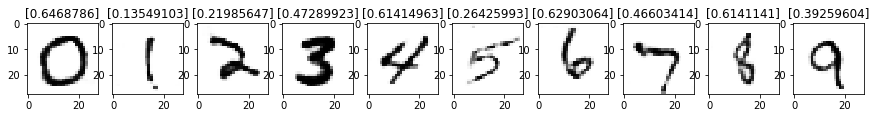

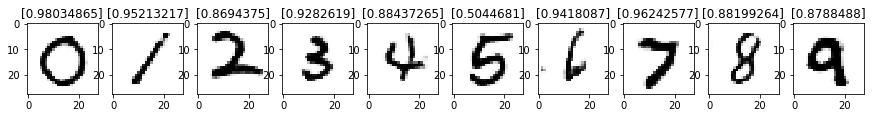

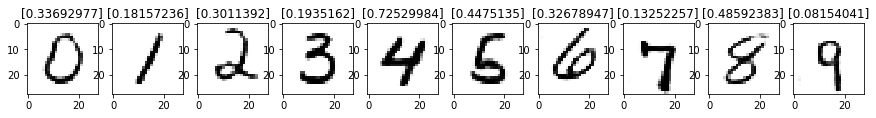

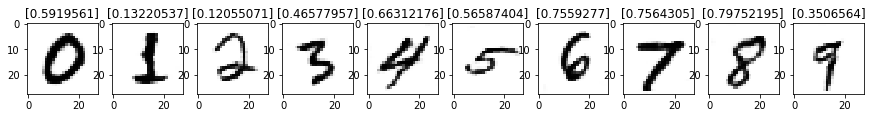

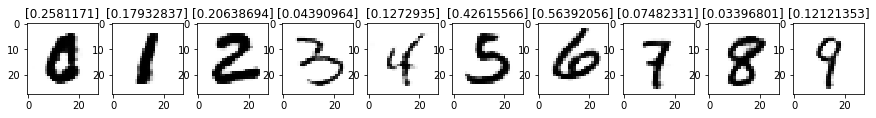

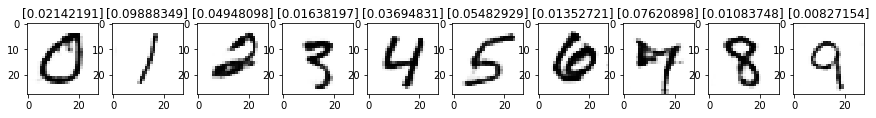

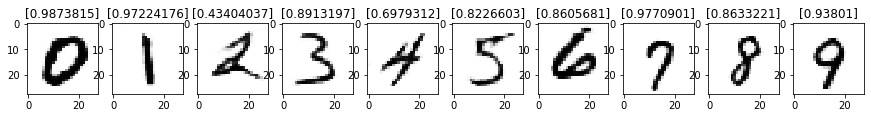

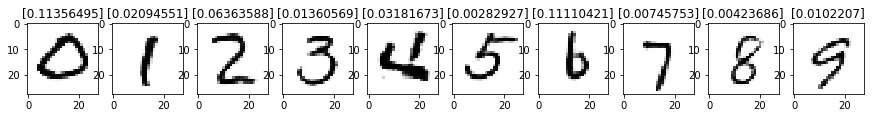

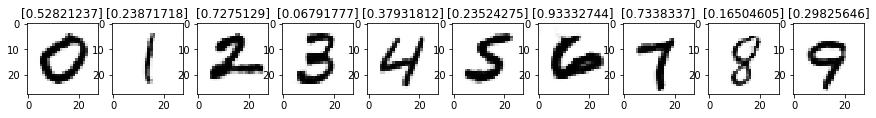

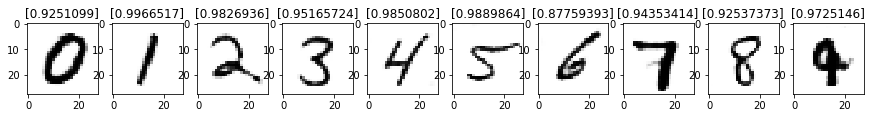

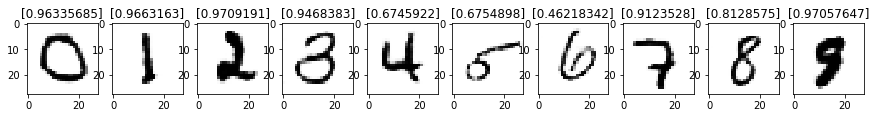

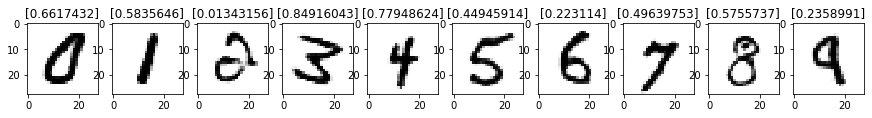

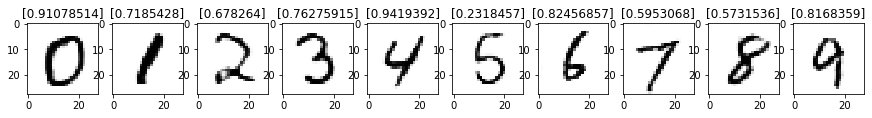

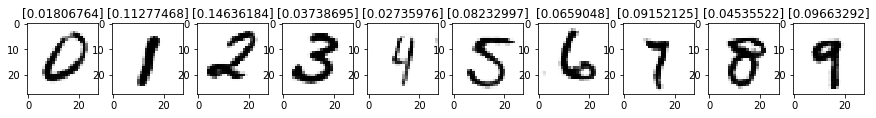

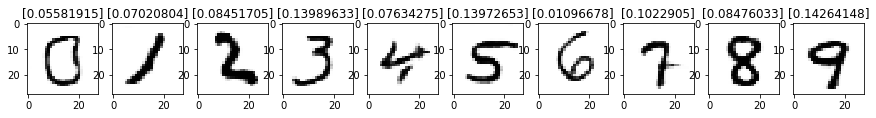

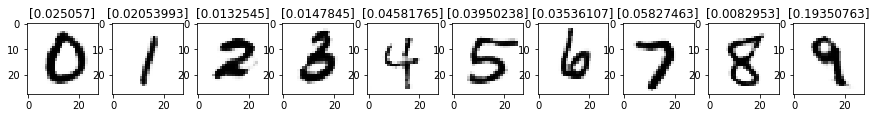

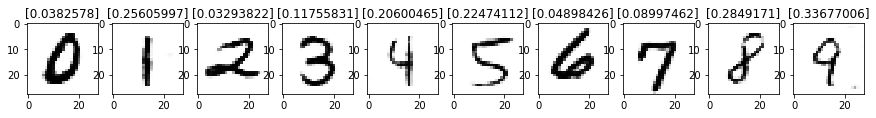

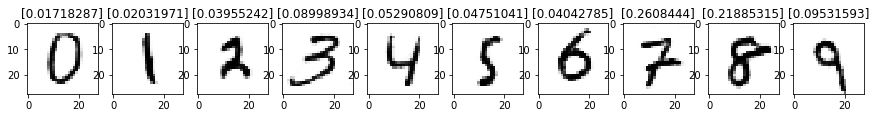

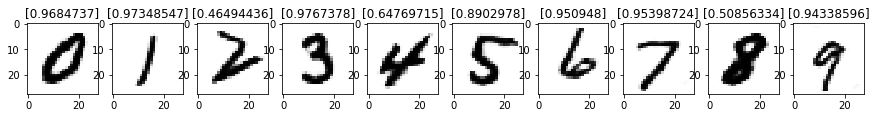

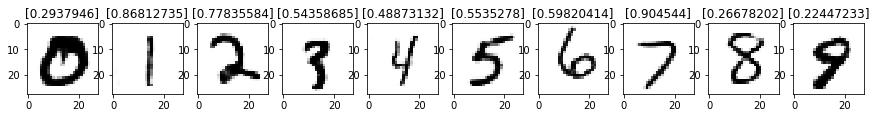

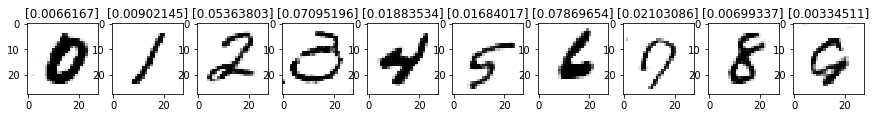

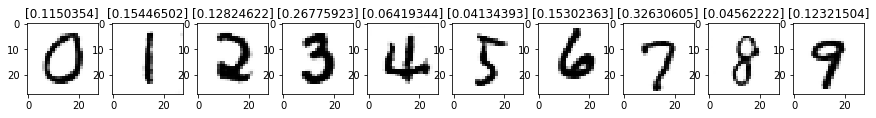

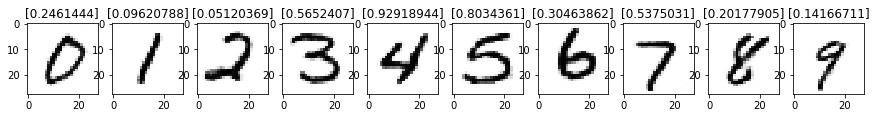

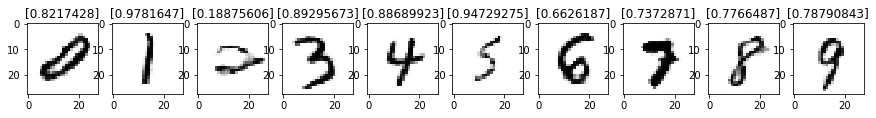

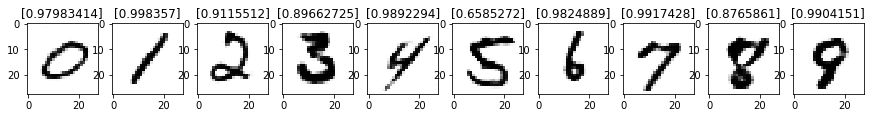

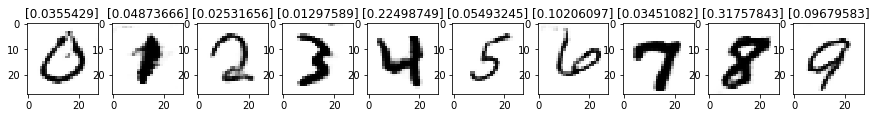

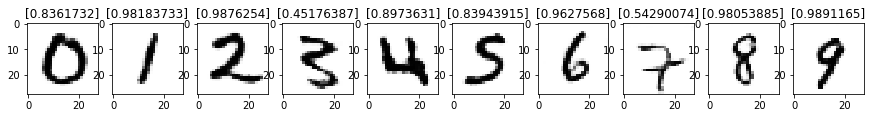

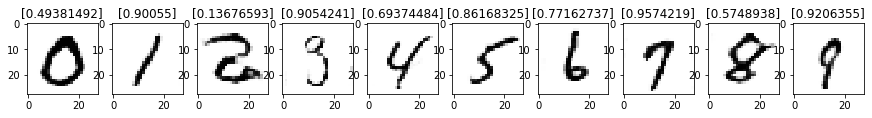

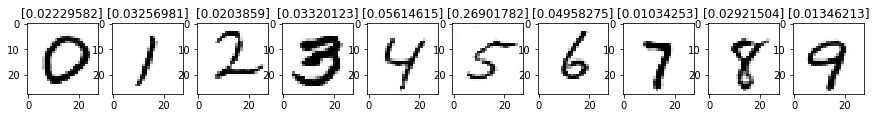

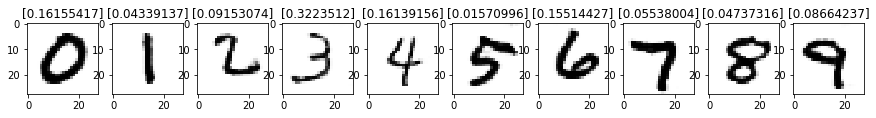

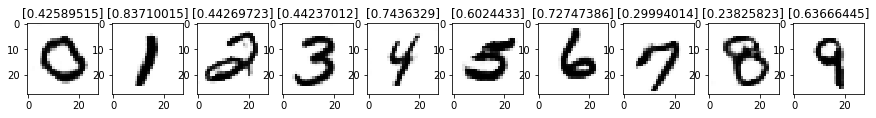

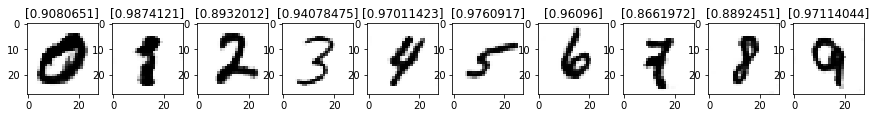

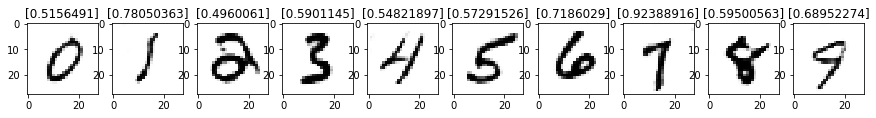

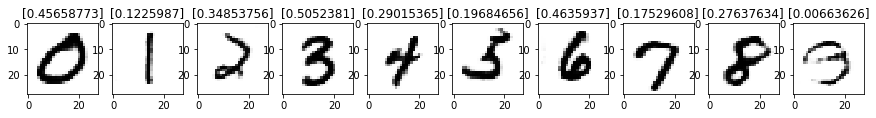

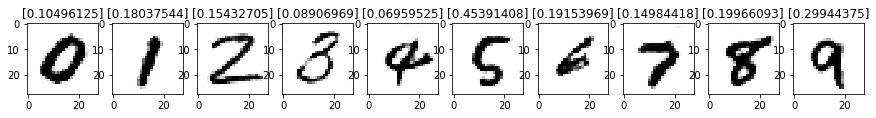

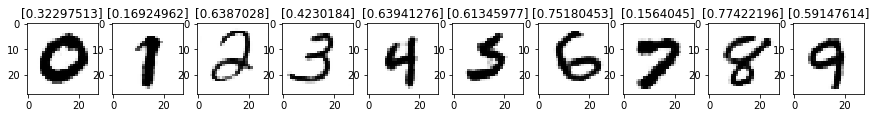

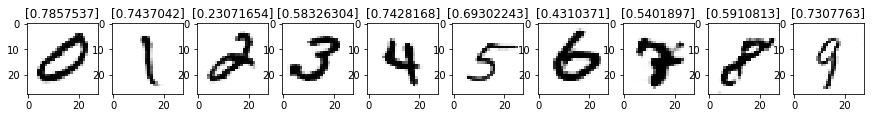

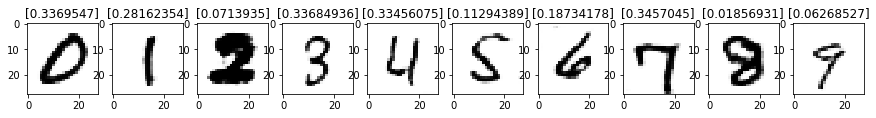

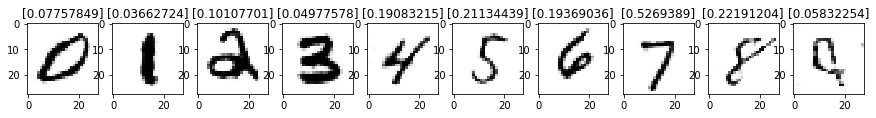

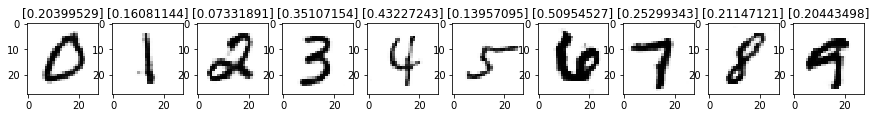

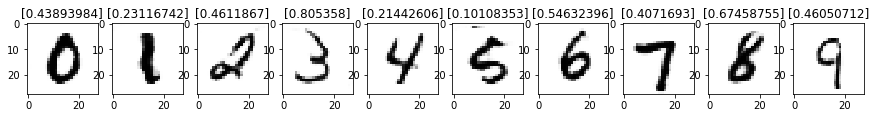

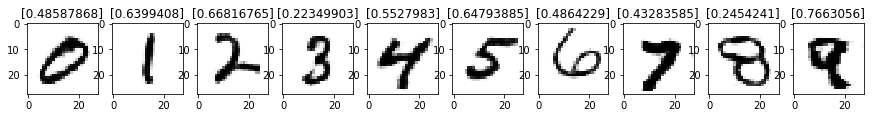

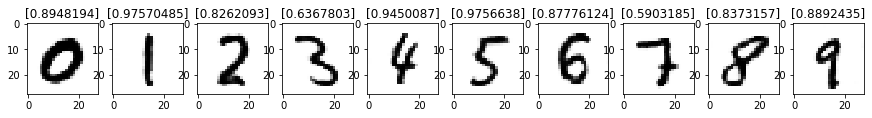

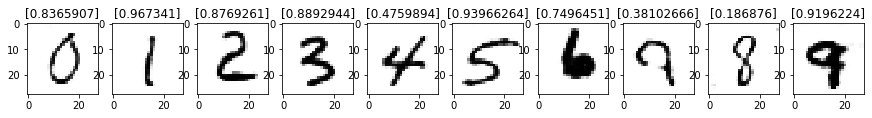

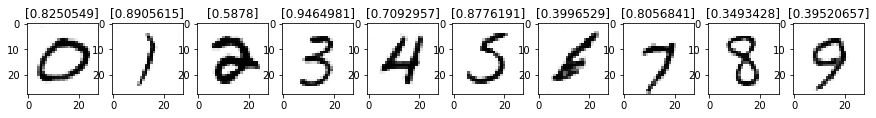

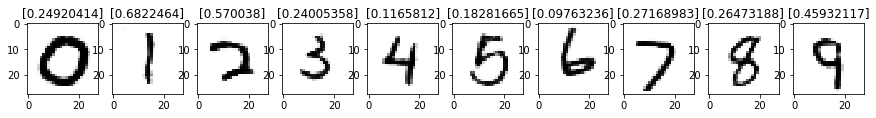

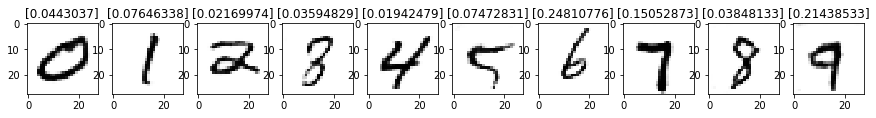

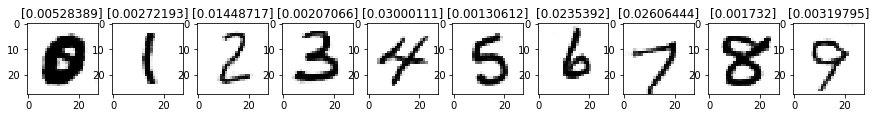

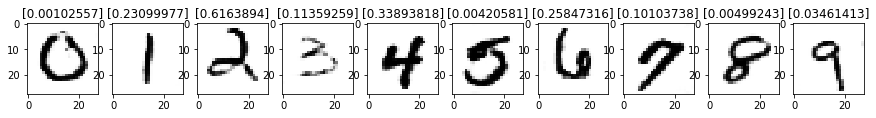

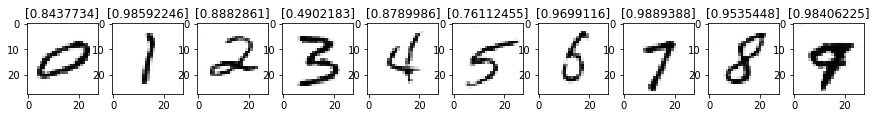

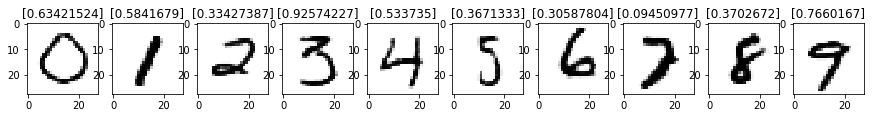

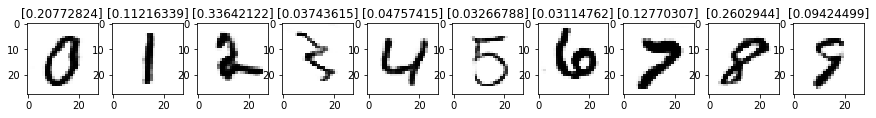

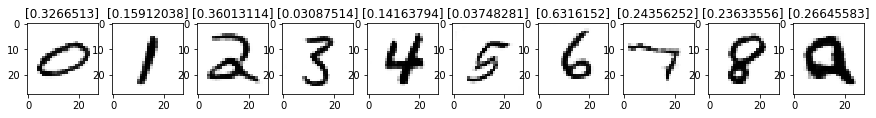

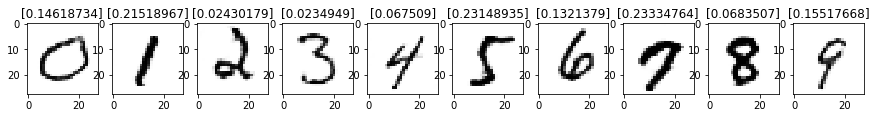

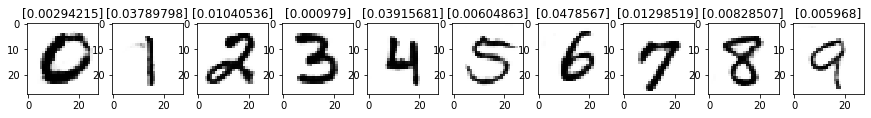

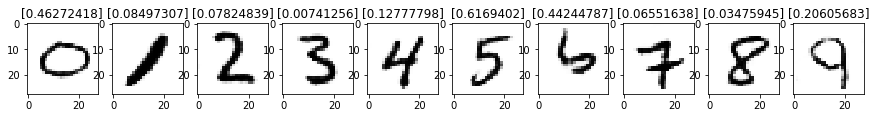

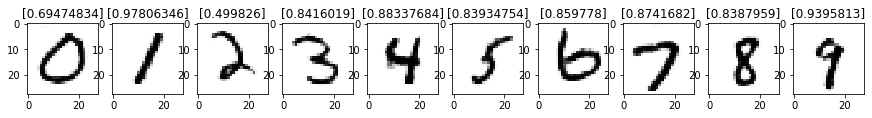

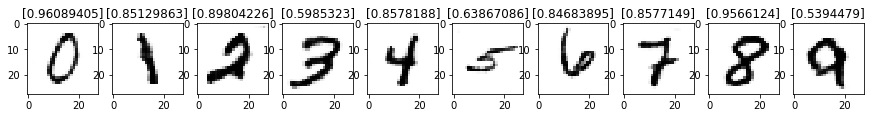

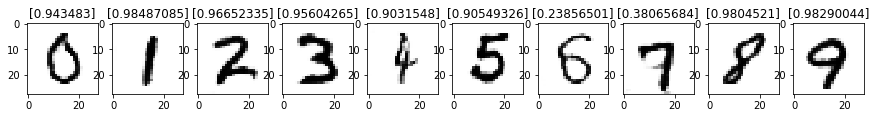

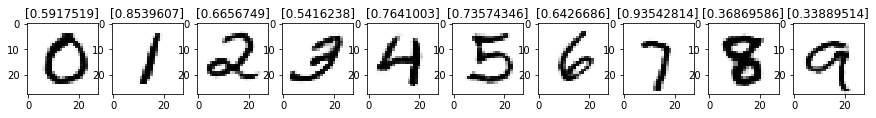

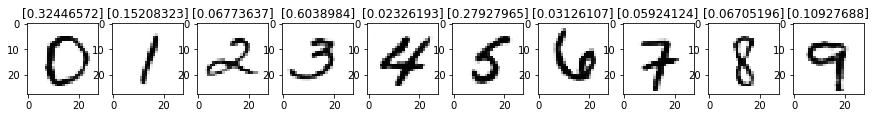

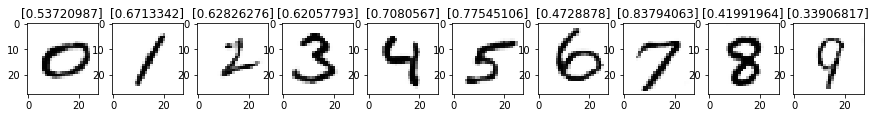

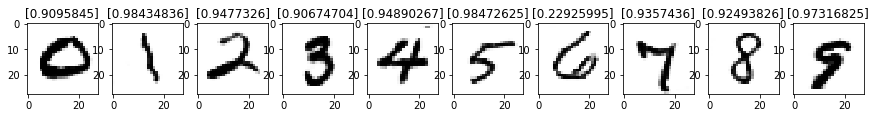

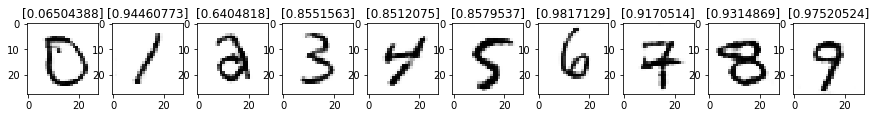

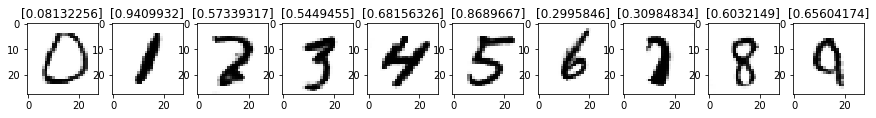

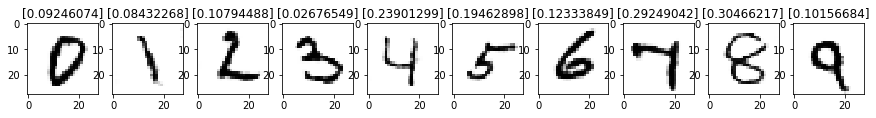

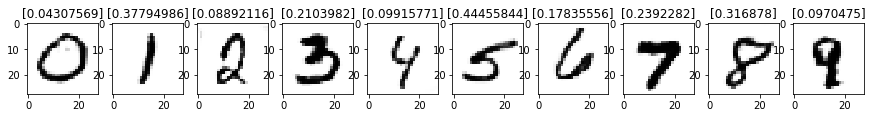

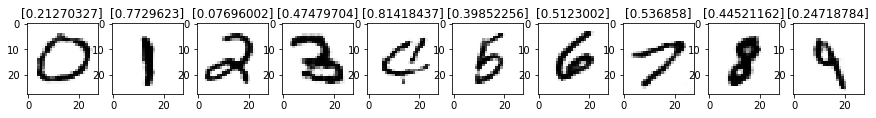

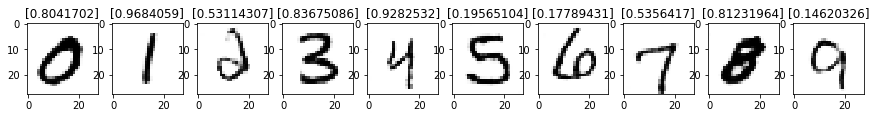

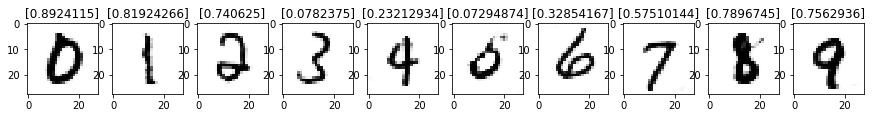

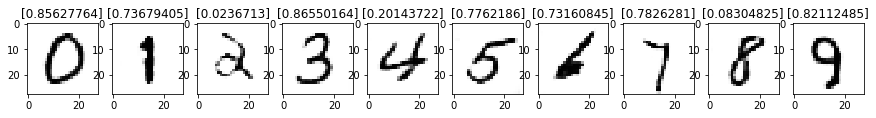

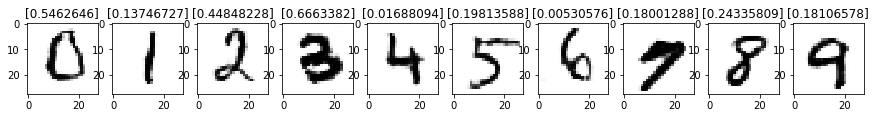

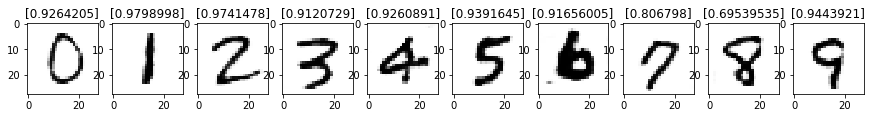

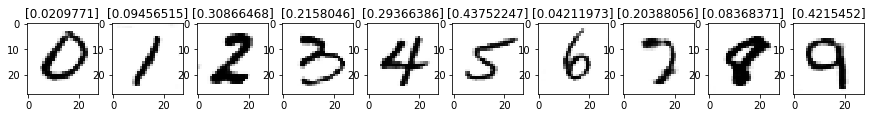

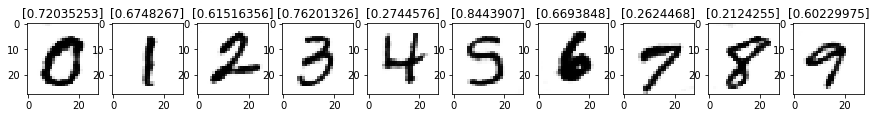

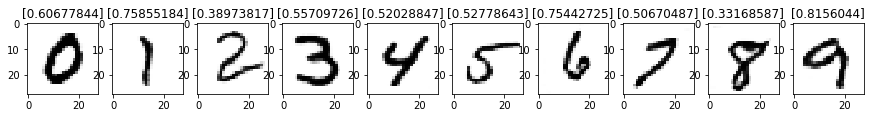

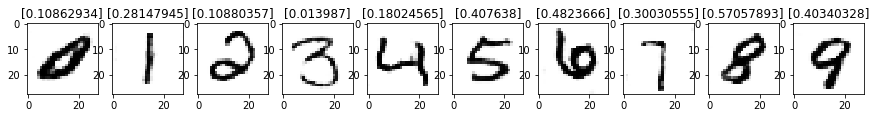

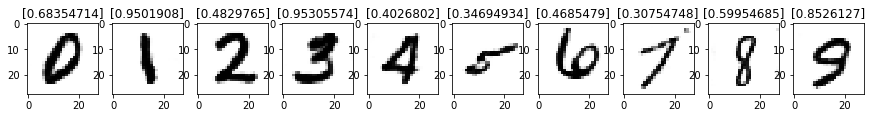

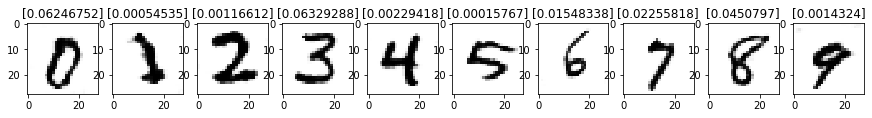

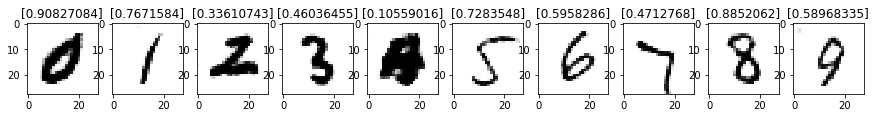

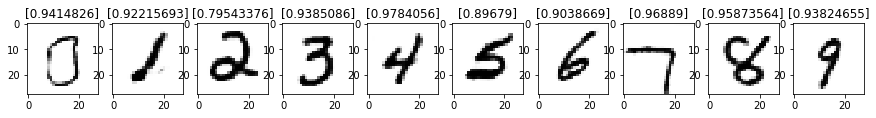

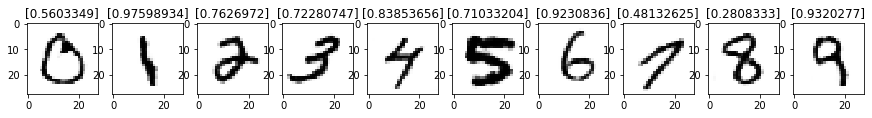

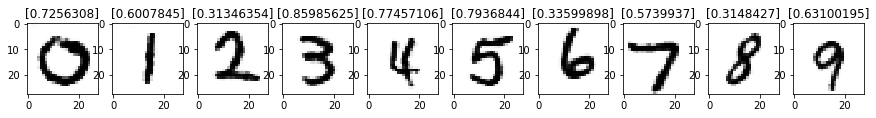

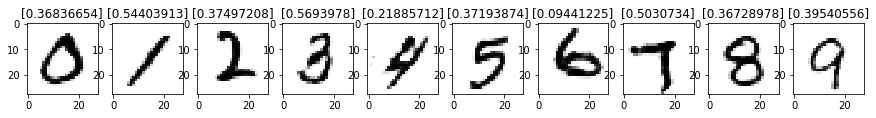

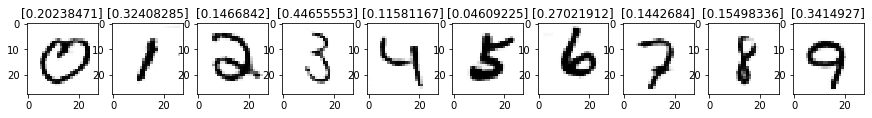

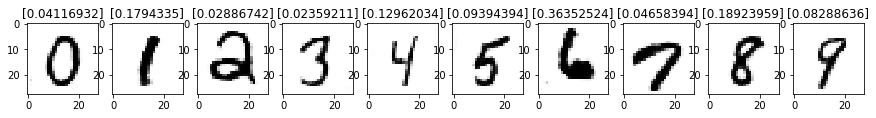

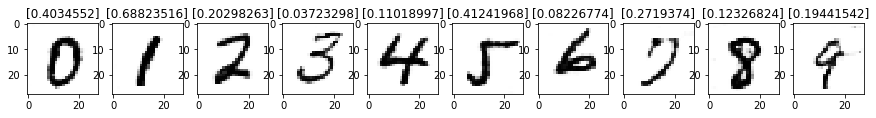

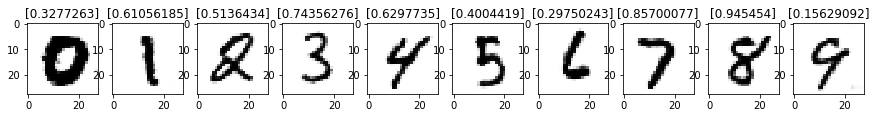

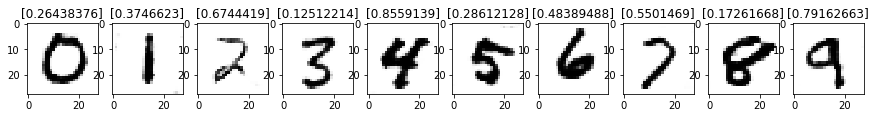

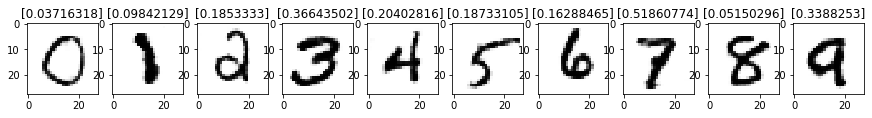

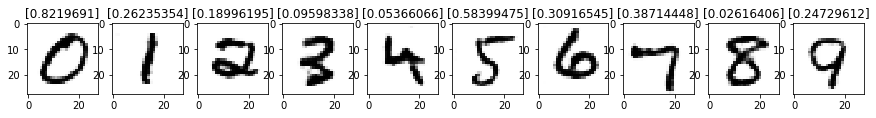

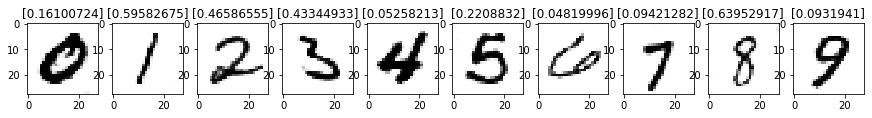

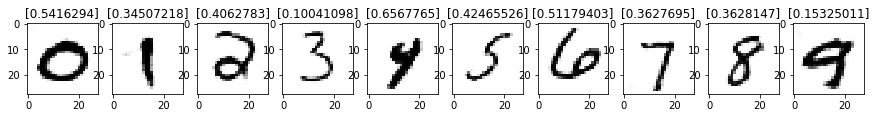

In [13]:
batch_size = 256

epochs = 134
disc_steps = 1
noise_level = 0.0

noise_shape = (100,)

def gen_loss(fake_pred):
    return cross_entropy(tf.ones_like(fake_pred),fake_pred)

def disc_loss(fake_pred, real_pred):
    loss_fake = cross_entropy(tf.zeros_like(fake_pred),fake_pred)
    loss_real = cross_entropy(tf.ones_like(real_pred),real_pred)
    return loss_fake + loss_real

@tf.function
def disc_step(x,y):
    noise = tf.random.normal(((len(x),)+noise_shape))
    with tf.GradientTape() as d_tape:
        x_pred = Gen([noise,y], training = True)
        fake_pred = Disc([x_pred,y], training = True)
        real_pred = Disc([x,y], training = True)
        loss_d = disc_loss(fake_pred, real_pred)

    gradients_d = d_tape.gradient(loss_d, Disc.trainable_variables)
    Disc_Op.apply_gradients(zip(gradients_d, Disc.trainable_variables))
    
    return tf.reduce_mean(loss_d)
    
@tf.function
def train_step(x,y):
    noise = tf.random.normal(((len(x),)+noise_shape))
    with tf.GradientTape() as g_tape, tf.GradientTape() as d_tape:
        x_pred = Gen([noise,y], training = True)
        fake_pred = Disc([x_pred,y], training = True)
        real_pred = Disc([x,y], training = True)
        loss_d = disc_loss(fake_pred, real_pred)
        loss_g = gen_loss(fake_pred)

    
    gradients_g = g_tape.gradient(loss_g, Gen.trainable_variables)
    Gen_Op.apply_gradients(zip(gradients_g, Gen.trainable_variables))

    gradients_d = d_tape.gradient(loss_d, Disc.trainable_variables)
    Disc_Op.apply_gradients(zip(gradients_d, Disc.trainable_variables))
    
    return tf.reduce_mean(loss_d), tf.reduce_mean(loss_g)
    
x_data = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(len(x_train)).batch(batch_size)
for epoch in range(epochs):
    disc_losses = []
    gen_losses = []
    
    bar = tqdm(enumerate(x_data), desc = 'Epoch ' + str(epoch+1), total = int(tf.data.experimental.cardinality(x_data))-2)
    for step, (x,y) in bar:
        if (step+1) % disc_steps == 0:
          loss_d, loss_g = train_step(x,y)
          disc_losses.append(loss_d.numpy())
          gen_losses.append(loss_g.numpy())
        else:
          loss_d = disc_step(x,y)
          disc_losses.append(loss_d.numpy())

        mean_disc_loss = np.mean(disc_losses) if len(disc_losses) > 0 else 0
        mean_gen_loss = np.mean(gen_losses) if len(gen_losses) > 0 else 0
        bar.set_postfix(disc_loss = mean_disc_loss, gen_loss = mean_gen_loss)
      
    plot()

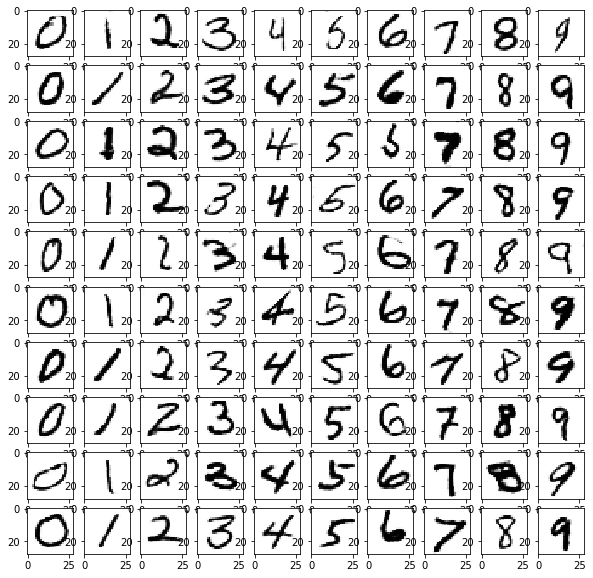

In [14]:
plt.figure(figsize = (10,10))
eye = np.float32(np.eye(10))
for i in range(10):
  im = Gen([tf.random.normal((10,100)),eye]).numpy().reshape(-1,28,28)
  for j in range(10):
    plt.subplot(10,10,10*i+j+1)
    plt.imshow(im[j],cmap='Greys')
plt.show()

In [0]:
plt.figure(figsize = (100,100))
for i in range(10):
    for j in range(10):
        plt.subplot(10,10,10*i+j+1)
        plt.imshow(x_test[i*10+j],cmap='Greys')
plt.show()